## Run the cells to generate charts for visualizing the benchmarks


### Original LayerSkip Visualizations

/var/folders/fx/wn3x6jds14n5jqpv881lj2_w0000gn/T/ipykernel_21430/370084874.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="dataset", y=metric, palette="viridis")


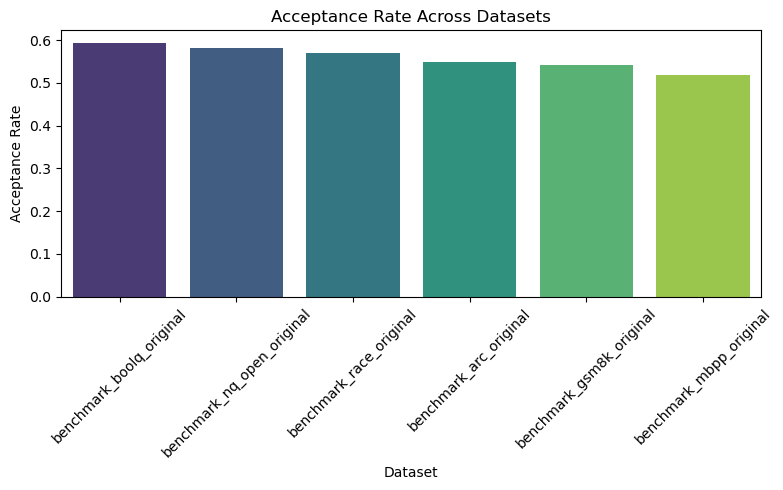

/var/folders/fx/wn3x6jds14n5jqpv881lj2_w0000gn/T/ipykernel_21430/370084874.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="dataset", y=metric, palette="viridis")


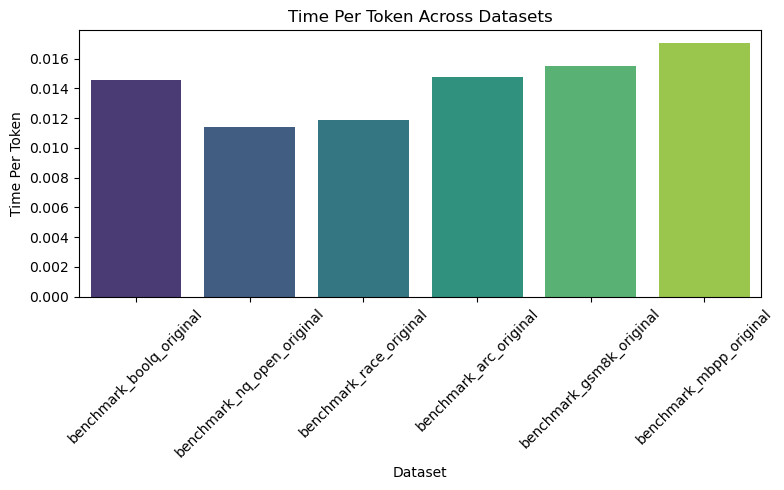

/var/folders/fx/wn3x6jds14n5jqpv881lj2_w0000gn/T/ipykernel_21430/370084874.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="dataset", y=metric, palette="viridis")


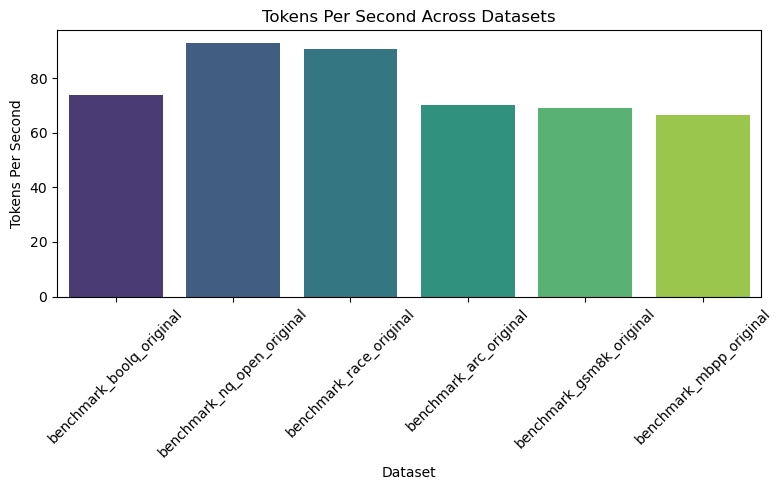

In [ ]:
import glob
import json
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

paths = glob.glob('OriginalLayerSkip/*.json')

metrics_list = []

for path in paths:
    with open(path, 'r') as f:
        content = f.read()
    
    json_objects = re.findall(r'\{.*?\}(?=\{|\Z)', content, flags=re.DOTALL)
    parsed_data = [json.loads(obj) for obj in json_objects]
    
    metrics = parsed_data[-1]
    
    data = {
        "dataset": path.split('/')[-1].replace('.json', ''),
        "acceptance_rate": metrics["acceptance_rate"]["mean"],
        "time_per_token": metrics["time_per_token"]["mean"],
        "tokens_per_second": metrics["tokens_per_second"]["mean"],
    }
    metrics_list.append(data)

df = pd.DataFrame(metrics_list)

metrics_to_plot = ["acceptance_rate", "time_per_token", "tokens_per_second"]

for metric in metrics_to_plot:
    plt.figure(figsize=(8, 5))
    sns.barplot(data=df, x="dataset", y=metric, palette="viridis")
    plt.title(f'{metric.replace("_", " ").title()} Across Datasets')
    plt.ylabel(metric.replace("_", " ").title())
    plt.xlabel('Dataset')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
